In [1]:
from io import BytesIO
from PIL import Image
import base64
from matplotlib import pyplot as plt
import requests
import json

# API Testing

Before begining, please start the service. If you are using docker:

```bash
docker run \         
    --gpus '"device=0"' \
    -v $path_to_where_you_want_to_store_the_models:/models \
    -v $path_to_the_config_file_that_you_wish_to_use:/config/config.yaml \
    -p 80:80 \
    -it diffusers_api:latest 
```

In [2]:
# Do not go over the model's max size
USE_HEIGHT = 1024
USE_WIDTH = 1024

BASE_URL = 'http://127.0.0.1:80'

### Text-to-Image

In [3]:
data = {
    'prompt' : ["ultra realistic close up portrait ((beautiful pale cyberpunk female with heavy black eyeliner))"],
    'negative_prompt' : [""],
    'height' : USE_HEIGHT,
    'width' : USE_WIDTH,
    'num_inference_steps' : 25,
    'guidance_scale':  7.0,
    'output_type' : 'PNG', # Here we test the output as a PNG file dinary data
    'sag_scale' : 1.0 # Ignored if model does not support SAG
}
headers = {'Accept': 'application/json', 'Content-Type': 'application/json'}

url = BASE_URL+'/text2img'


# Make the request
response = requests.post(url, headers=headers, json=data)

# Print generation data
json_response = json.loads(response.text)
for key in json_response.keys():
    if key not in ["output"]:
        print(key, json_response[key])

status success
generationTime 8.301624774932861
id 0


In [4]:
# Retrieve generated image

# Decode image data
decoded_data = base64.b64decode(json_response['output'][0])
# Load into PIL
if data.get('output_type', '') != '': # This is in case you want to comment the "output_type" field, in that case you will receive a PIL image raw bytes
    output_image = Image.open(BytesIO(decoded_data))
else:
    output_image = Image.frombytes('RGB', (USE_WIDTH,USE_HEIGHT), decoded_data, 'raw')

### Image+Text-to-Image

In [5]:
data = {
    'prompt' : ["big scars battle"],
    'negative_prompt' : [""],
    'base_img_data' : {
        'img_data' : [],
        'img_data_format': 'raw_bytes',
        'img_type': 'RGB',
        'img_height': USE_HEIGHT,
        'img_width': USE_WIDTH,
    },
    'height' : USE_HEIGHT,
    'width' : USE_WIDTH,
    'num_inference_steps' : 50,
    'guidance_scale':  25.0
}
headers = {'Accept': 'application/json', 'Content-Type': 'application/json'}

url = BASE_URL+'/img2img'

# Encode image data to send it to the API
data['base_img_data']['img_data'].append(base64.b64encode(output_image.tobytes()).decode("utf-8"))

response = requests.post(url, headers=headers, json=data)

In [6]:
# Print generation data
json_response = json.loads(response.text)
for key in json_response.keys():
    if key not in ["output"]:
        print(key, json_response[key])

status success
generationTime 5.510880947113037
id 0


In [7]:
# Load image 
decoded_data = base64.b64decode(json_response['output'][0])
refined_output_image = Image.frombytes('RGB', (USE_WIDTH,USE_HEIGHT), decoded_data, 'raw')

### Inpainting


In [8]:
data = {
    'prompt' : ["blue flames fire big"],
    'negative_prompt' : [""],
    'base_img_data' : {
        'img_data' : [],
        'img_data_format': 'raw_bytes',
        'img_type': 'RGB',
        'img_height': USE_HEIGHT,
        'img_width': USE_WIDTH,
    },
    'mask_img_data' : {
        'img_data' : [],
        'img_data_format': 'raw_bytes',
        'img_type': 'RGB',
        'img_height': USE_HEIGHT,
        'img_width': USE_WIDTH,
    },
    'height' : USE_HEIGHT,
    'width' : USE_WIDTH,
    'num_inference_steps' : 50,
    'guidance_scale':  15,
    'strength':  0.99,
    'aesthetic_score': 6,
    'negative_aesthetic_score': 2.5
}
headers = {'Accept': 'application/json', 'Content-Type': 'application/json'}

url = BASE_URL+'/inpainting'

data['base_img_data']['img_data'].append(base64.b64encode(refined_output_image.tobytes()).decode("utf-8"))

# Read mask image
mask_image = Image.open('./mask_test.png').resize(refined_output_image.size)

# Now we will send it as a PNG, just because
in_file = open("./mask_test.png", "rb") 
file_data = in_file.read() 
in_file.close()
data['mask_img_data']['img_data'].append(base64.b64encode(file_data).decode("utf-8"))
data['mask_img_data']['img_data_format'] = 'file_bytes' # This flags that the bytes are the content of a file, not a PIL image


response = requests.post(url, headers=headers, json=data)

In [9]:
# Print generation data
json_response = json.loads(response.text)
for key in json_response.keys():
    if key not in ["output"]:
        print(key, json_response[key])

status success
generationTime 16.186929941177368
id 0


In [10]:
# Get image
decoded_data = base64.b64decode(json_response['output'][0])
inpaint_output_image = Image.frombytes('RGB', (USE_WIDTH,USE_HEIGHT), decoded_data, 'raw')

### Result

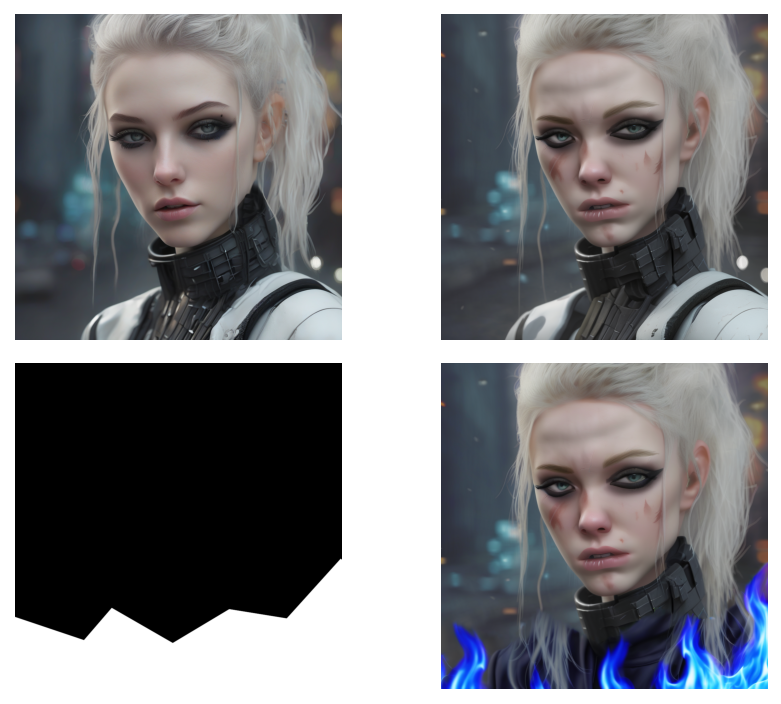

In [11]:
plt.figure(dpi=150)
plt.subplot(2,2,1)
plt.imshow(output_image)
plt.axis("off")
plt.subplot(2,2,2)
plt.imshow(refined_output_image)
plt.axis("off")
plt.subplot(2,2,3)
plt.imshow(mask_image)
plt.axis("off")
plt.subplot(2,2,4)
plt.imshow(inpaint_output_image)
plt.axis("off")
plt.tight_layout()
plt.show()